#### Import required packages

In [222]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
from importlib import reload
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import glob
import os
import shutil
from mpmath import sec
import matplotlib.colors as colors
import math
from numpy.linalg import norm
import pyproj
from function_dumpster import *

### Load data

In [224]:
FDHI_data = pd.read_excel('FDHI_data/data_FDHI.xlsx') # FDHI data
california_rows = FDHI_data[FDHI_data['region'] == 'California']
unique_eq_names = california_rows['eq_name'].unique()
data_for_calc = pd.read_csv('FDHI_data/extra_data.csv') # additional info (not in FDHI database, refs in excel file)
slip_data = pd.read_csv("FDHI_data/A02_FDHI_FLATFILE_MEASUREMENTS_20220719.csv") # slip data from FDHI appendix 
CA_slip_data = slip_data[slip_data['region'] == 'California']
event_data = pd.read_excel('FDHI_data/event_data.xlsx')
CA_event_data = event_data[event_data['event'].isin(unique_eq_names)]
stress_data = pd.read_csv("SCEC_CSM_archive_2023/Hardebeck_FM.csv", skiprows=47) # Hardebeck community stress model
depth_choice = 5 # subset stress at depth slice of choice - dafult 5 km
stress_data_depthslice = stress_data[stress_data['DEP'] == depth_choice]
CA_event_data['Zone_numeric'] = CA_event_data['zone'].str[:-1] # UTM zones for each event
# Define the directory where the shapefiles are located
shapefile_directory = 'ECS_lines_CA'

/var/folders/bw/pbfwt2p16s729kbshjt5y7900000gr/T/ipykernel_18391/2561576221.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_event_data['Zone_numeric'] = CA_event_data['zone'].str[:-1] # UTM zones for each event


### Extract and visualize stress data

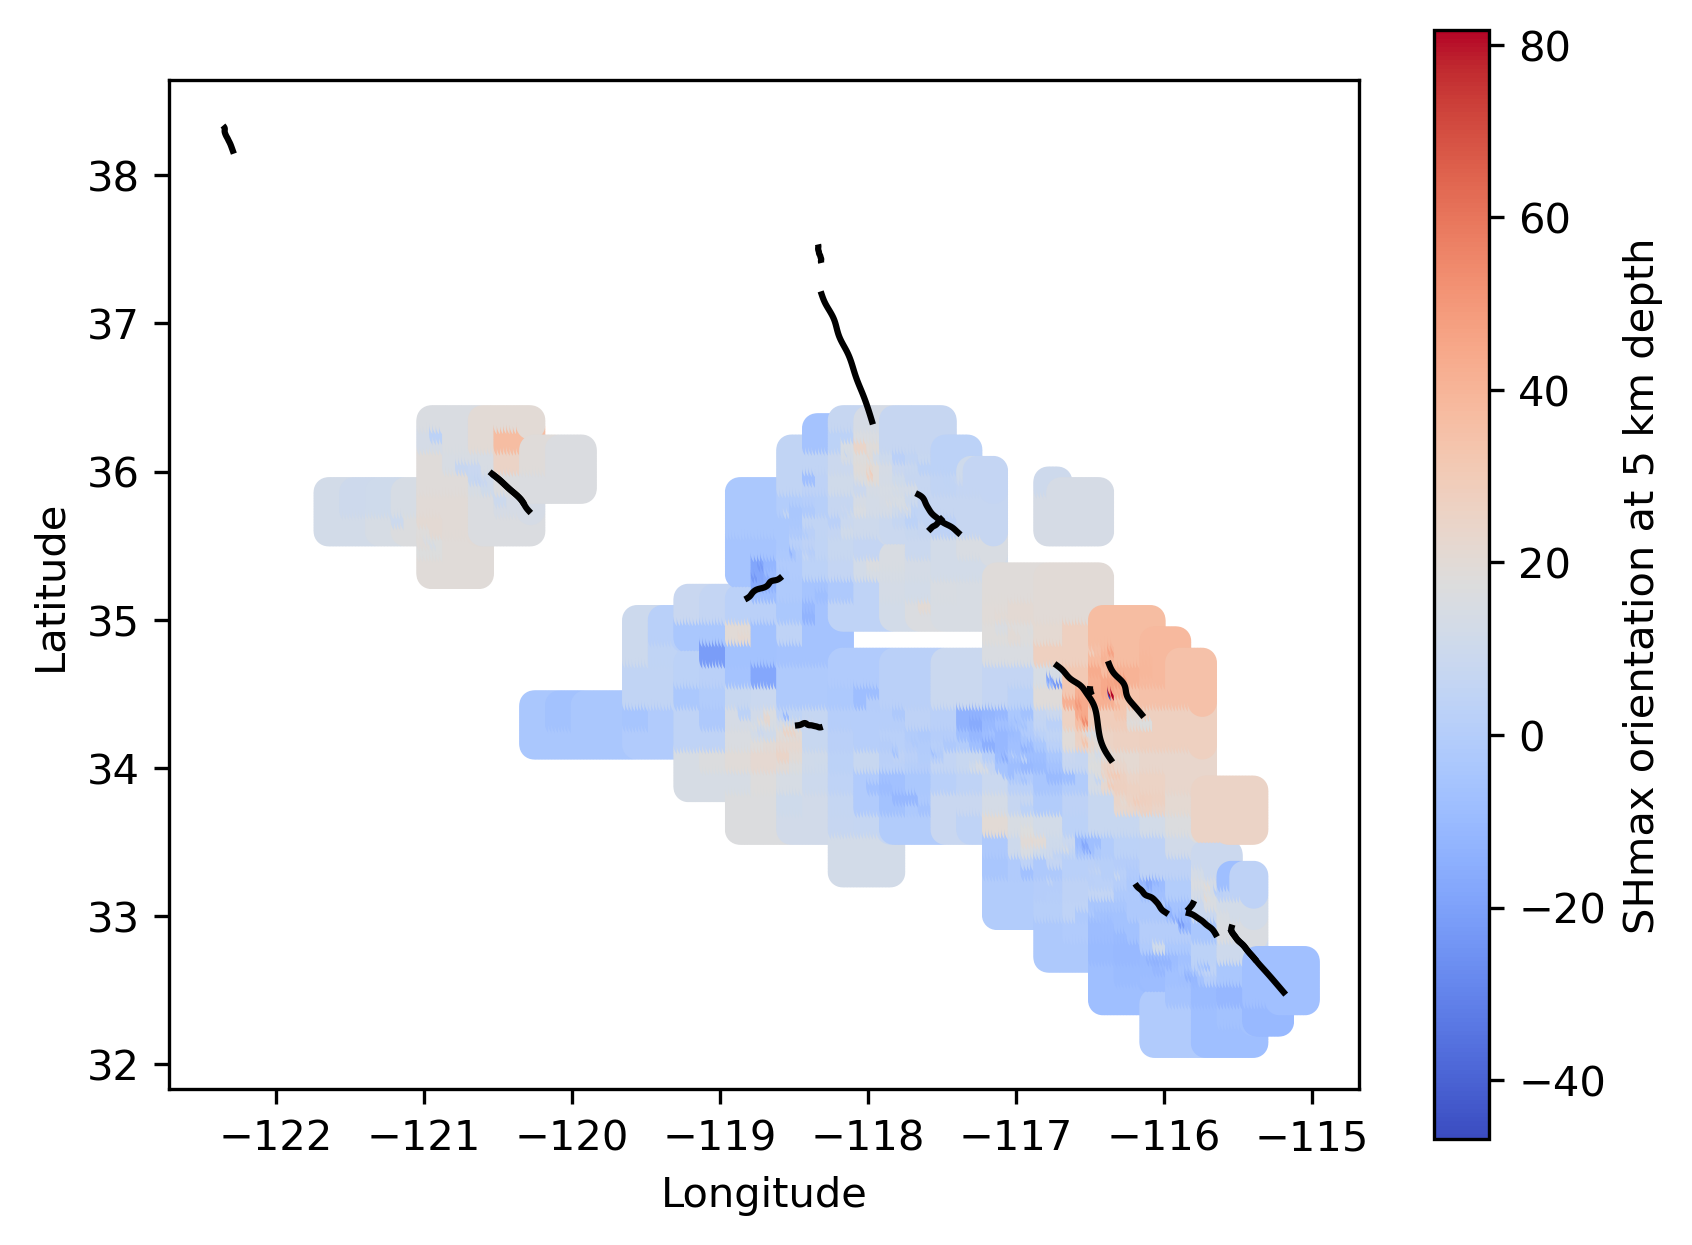

In [225]:
# Assuming 'stress_data_depthslice' is your DataFrame
xstress = stress_data_depthslice['LON']
ystress = stress_data_depthslice['LAT']
SHmax = stress_data_depthslice['SHmax']

plt.figure(dpi=300)
plt.scatter(xstress, ystress, c=SHmax, cmap='coolwarm', marker='o')
plt.colorbar(label='SHmax orientation at 5 km depth')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# plot ECS lines for each event on top of stress map 
shapefile_paths = glob.glob(os.path.join(shapefile_directory, '*.shp'))
for shapefile_path in shapefile_paths:
    gdf = gpd.read_file(shapefile_path)
    gdf.plot(ax=plt.gca(), color='black')  # Specify the current axis using plt.gca()
    
plt.savefig('Figures/stressmap_CA.pdf',bbox_inches='tight',dpi=300)
plt.show()

### Measure fault segment angle differences

In [226]:
# variables that can be modified
plot_ON_OFF = 'off' # set whether plot of segment orientations gets made
stress_ON_OFF = 'on' # set whether stress field will get plotted too (fast, but extra calculations)
step = 10 # for downsampling really dense ECS lines, n of points to skip, default 1 if not set
vmin = 0 # to define angle color-coding range if plot on
vmax = 6
mag = 2000 # for vector arrow size in visualization, default 2000 if not set

In [227]:
segment_angle_differences = []
for i, shapefile_path in enumerate(shapefile_paths):
    # get shapefile and event data
    shapefilename_path = shapefile_path.rsplit('/', 1)
    shapefilename = str(shapefilename_path[1])
    split_parts = shapefilename.split('_ECS.shp')
    eventname = split_parts[0]
    matching_rows = CA_event_data[CA_event_data['event'] == eventname]
    if eventname in ['SanFernando', 'ChalfantValley', 'OwensValley', 'Kern','Napa']: # remove non strike-slip events and events without stress data 
        continue   
    target_utm_zone = matching_rows['Zone_numeric'].to_numpy()
    target_utm_zone = int(target_utm_zone[0])
    utm_crs = f"+proj=utm +zone={target_utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    slip_event = CA_slip_data[CA_slip_data['eq_name'] == eventname]

    # Extract the x and y coordinates from the shapefile in UTM format
    x_coords,y_coords = extract_coordinates_shapefile(shapefile_path, target_utm_zone,step)

    # Calculate the angle of each line segment for vertex pairs
    angles = measure_angle_between_segments(x_coords, y_coords)
    segment_angle_differences.append(angles)
    
    if plot_ON_OFF == 'on': 
        fig, ax = plt.subplots(dpi=300)
        if stress_ON_OFF == 'on':
            # apply coordinate transformation, crop stress to match dimensions of event, and plot vector field
            xstress_utm, ystress_utm = extract_coordinates_stress(utm_crs, ystress, xstress)
            cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax = crop_stress_to_event(x_coords, y_coords,xstress_utm, ystress_utm, SHmax)
            ustress,vstress = unit_vector_stress(cropped_SHmax,mag)
            plt.quiver(cropped_xstress_utm, cropped_ystress_utm, ustress,vstress, angles='xy', scale_units='xy', scale=1, color='black', label='SHmax Orientation')
        else: 
            continue
        plot_segments_color_angle(vmin,vmax,x_coords,y_coords,angles,eventname)
        utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
        plt.scatter(utm_hypox, utm_hypoy, c='black', marker='*', s=100)

### Measure fault strike and fracture angle (shmax - strike)

In [228]:
# variables that can be modified
plot_ON_OFF = 'off' # set whether plot of segment orientations gets made
step = 10 # for downsampling really dense ECS lines, n of points to skip, default 1 if not set
vmin=0
vmax=90
mid_val=30
mag = 2000 # for vector arrow size in visualization, default 2000 if not set

In [229]:
fracture_angles = []
fault_segment_strikes= []
shmax_all_segments = []

for i, shapefile_path in enumerate(shapefile_paths):
    # get shapefile and event data
    shapefilename_path = shapefile_path.rsplit('/', 1)
    shapefilename = str(shapefilename_path[1])
    split_parts = shapefilename.split('_ECS.shp')
    eventname = split_parts[0]
    matching_rows = CA_event_data[CA_event_data['event'] == eventname]
    target_utm_zone = matching_rows['Zone_numeric'].to_numpy()
    target_utm_zone = int(target_utm_zone[0])
    utm_crs = f"+proj=utm +zone={target_utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    slip_event = CA_slip_data[CA_slip_data['eq_name'] == eventname]
    if eventname in ['SanFernando', 'ChalfantValley', 'OwensValley', 'Kern','Napa']: # remove non strike-slip events and events without stress data 
        continue 
    # Extract the x and y coordinates from the shapefile in UTM format
    x_coords,y_coords = extract_coordinates_shapefile(shapefile_path, target_utm_zone,step)

    # Calculate the strike of each fault segment
    angles = measure_fault_strike(x_coords, y_coords)
    fault_segment_strikes.append(angles)
    
    # Calculate angle between each segment pair strike and nearest stress vector
    xstress_utm, ystress_utm = extract_coordinates_stress(utm_crs, ystress, xstress)
    cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax = crop_stress_to_event(x_coords, y_coords,xstress_utm, ystress_utm, SHmax)
    diff_angle, SHmax_segment = measure_fracture_angle(x_coords, y_coords, angles, cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax)
    fracture_angles.append(diff_angle)
    shmax_all_segments.append(SHmax_segment)

    if plot_ON_OFF == 'on':
        plt.figure(dpi=300)  
        # apply coordinate transformation, crop stress to match dimensions of event, and plot vector field    
        ustress,vstress = unit_vector_stress(cropped_SHmax,mag)
        plt.quiver(cropped_xstress_utm, cropped_ystress_utm, ustress,vstress, angles='xy', scale_units='xy', scale=1, color='black', label='SHmax Orientation')
        plot_segments_color_fracture_angle(vmin,vmax,mid_val,x_coords,y_coords,diff_angle,eventname)
        utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
        plt.scatter(utm_hypox, utm_hypoy, c='black', marker='*', s=100)

### Visualize and analyze distribution of fracture angle, fracture strike, and segment angle differences

In [230]:
# flatten angle arrays
segment_angle_differences_flattened = list(chain.from_iterable(segment_angle_differences))
fracture_angles_flattened = list(chain.from_iterable(fracture_angles))
fault_segment_strikes_flattened = list(chain.from_iterable(fault_segment_strikes))
shmax_all_segments_flattened = list(chain.from_iterable(shmax_all_segments))

plot_ON_OFF = 'off' # set whether histograms get plotted

In [231]:
if plot_ON_OFF == 'on':
    plt.figure(figsize=(4,6),dpi=300)
    plot_angle_distribution(311,segment_angle_differences_flattened,10,'lightsalmon','Segment strike difference')
    plot_angle_distribution(312,fault_segment_strikes_flattened,10,'goldenrod','Fault segment strike')
    plot_angle_distribution(313,fracture_angles_flattened,10,'darkkhaki',r'Fracture angle $\phi_s$')
    plt.tight_layout()
    plt.show()

### Associate slip measurements to fault segments


In [232]:
# variables that can be modified
plot_ON_OFF = 'off' # set whether plot of segment orientations gets made
vmin=0
vmax=5
mid_val=30
num_closest = 1 # for n of displacement measurements considered per segment

In [233]:
fault_max_slip = []
strain_drop_all = []
rupture_width_all_events = []
rupture_length_all_events = []

for i, shapefile_path in enumerate(shapefile_paths):
    # get shapefile and event data
    shapefilename_path = shapefile_path.rsplit('/', 1)
    shapefilename = str(shapefilename_path[1])
    split_parts = shapefilename.split('_ECS.shp')
    eventname = split_parts[0]
    matching_rows = CA_event_data[CA_event_data['event'] == eventname]
    target_utm_zone = matching_rows['Zone_numeric'].to_numpy()
    target_utm_zone = int(target_utm_zone[0])
    utm_crs = f"+proj=utm +zone={target_utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    slip_event = CA_slip_data[CA_slip_data['eq_name'] == eventname]
    # get width and length of rupture for later calculations
    row_with_event = data_for_calc[data_for_calc['Event'] == eventname]
    rupture_width = row_with_event['Width (km)']
    rupture_length = row_with_event['Rupture length (m)']
    if eventname in ['SanFernando', 'ChalfantValley', 'OwensValley', 'Kern','Napa']: # remove non strike-slip events and events without stress data 
        continue 
    # Extract the x and y coordinates from the shapefile in UTM format
    x_coords,y_coords = extract_coordinates_shapefile(shapefile_path, target_utm_zone,step)
    # Prep slip data for each event by removing -999 and 0s (allowing geodetic + field slip)
    slipx, slipy, slip_preferred = prepare_slip_data(slip_event,utm_crs)
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    max_slip_preferred = match_slip_to_segment(x_coords, y_coords, slipx, slipy, slip_preferred, num_closest)
    fault_max_slip.append(max_slip_preferred)

    # Calculate angle between each segment pair strike and nearest stress vector
    xstress_utm, ystress_utm = extract_coordinates_stress(utm_crs, ystress, xstress)
    cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax = crop_stress_to_event(x_coords, y_coords,xstress_utm, ystress_utm, SHmax)
    
    # Calculate strain drop (for later)
    strain_drop = calculate_strain_drop(x_coords,y_coords,max_slip_preferred)
    strain_drop_all.append(strain_drop)
    rupture_width_all_events.append(np.array(np.repeat(rupture_width,len(strain_drop))))
    rupture_length_all_events.append(np.array(np.repeat(rupture_length,len(strain_drop))))

    if plot_ON_OFF == 'on':
        plt.figure(dpi=300)  
        # apply coordinate transformation, crop stress to match dimensions of event, and plot vector field    
        ustress,vstress = unit_vector_stress(cropped_SHmax,mag)
        plt.quiver(cropped_xstress_utm, cropped_ystress_utm, ustress,vstress, angles='xy', scale_units='xy', scale=1, color='black', label='SHmax Orientation')
        log_slip_preferred = np.log10(slip_preferred)  # Taking logarithm of the color values
        plt.scatter(slipx, slipy, s=20, c=log_slip_preferred,cmap='magma',alpha=0.4,edgecolors='none')
        plot_segments_slip_color(x_coords,y_coords,max_slip_preferred,eventname,vmin,vmax)
        utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
        plt.scatter(utm_hypox, utm_hypoy, c='black', marker='*', s=100)

### Extract additional info for friction models

In [234]:
flattened_rupture_width_all_events = [element for sublist in rupture_width_all_events for element in sublist]
flattened_rupture_length_all_events = [element for sublist in rupture_length_all_events for element in sublist]

In [235]:
postseismic_rotation = 10 # let's go MC on this later
W = flattened_rupture_width_all_events*1000 # m
W = [element * 1000 for element in W]
G = 30*10**10 # 30 GPa
L = flattened_rupture_length_all_events # m

### Estimate parameters for friction model

In [236]:
C = [] # geometrical term from Aki (1972) and Milliner et al. (2022)
for Wi,Li in zip(W,L):
    Ci = (2/np.pi)*np.sqrt(Li/Wi) # Aki (1972) and Milliner et al. (2022)
    C.append(Ci)

stress_drop = [x * G for x in strain_drop] # local stress drops per segment

max_shear_stress = []
for shmax_all_segments_flattenedi,stress_dropi in zip(shmax_all_segments_flattened,stress_drop):
    max_shear_stress.append(estimate_max_shear_stress(postseismic_rotation,shmax_all_segments_flattenedi,stress_dropi))

delta_sigma_c = max_shear_stress # only works for vertical strike-slip fauls, where stress on the fault is located on max Mohr circle
lambda_s = 1 #max_shear_stress/delta_sigma_c

tau_initial = []
for angle, max_shear_stressi in zip(fracture_angles_flattened,max_shear_stress):
    tau_initial.append(estimate_tau_initial(max_shear_stressi,angle))

static_friction = []
for angle in zip(fracture_angles_flattened):
    static_friction.append(estimate_static_friction(angle))

effective_normal_stress_initial = []
for stress,friction in zip(tau_initial,static_friction):
    effective_normal_stress_initial.append(estimate_effective_normal_stress_initial(stress,friction))

### Some quick visualizations

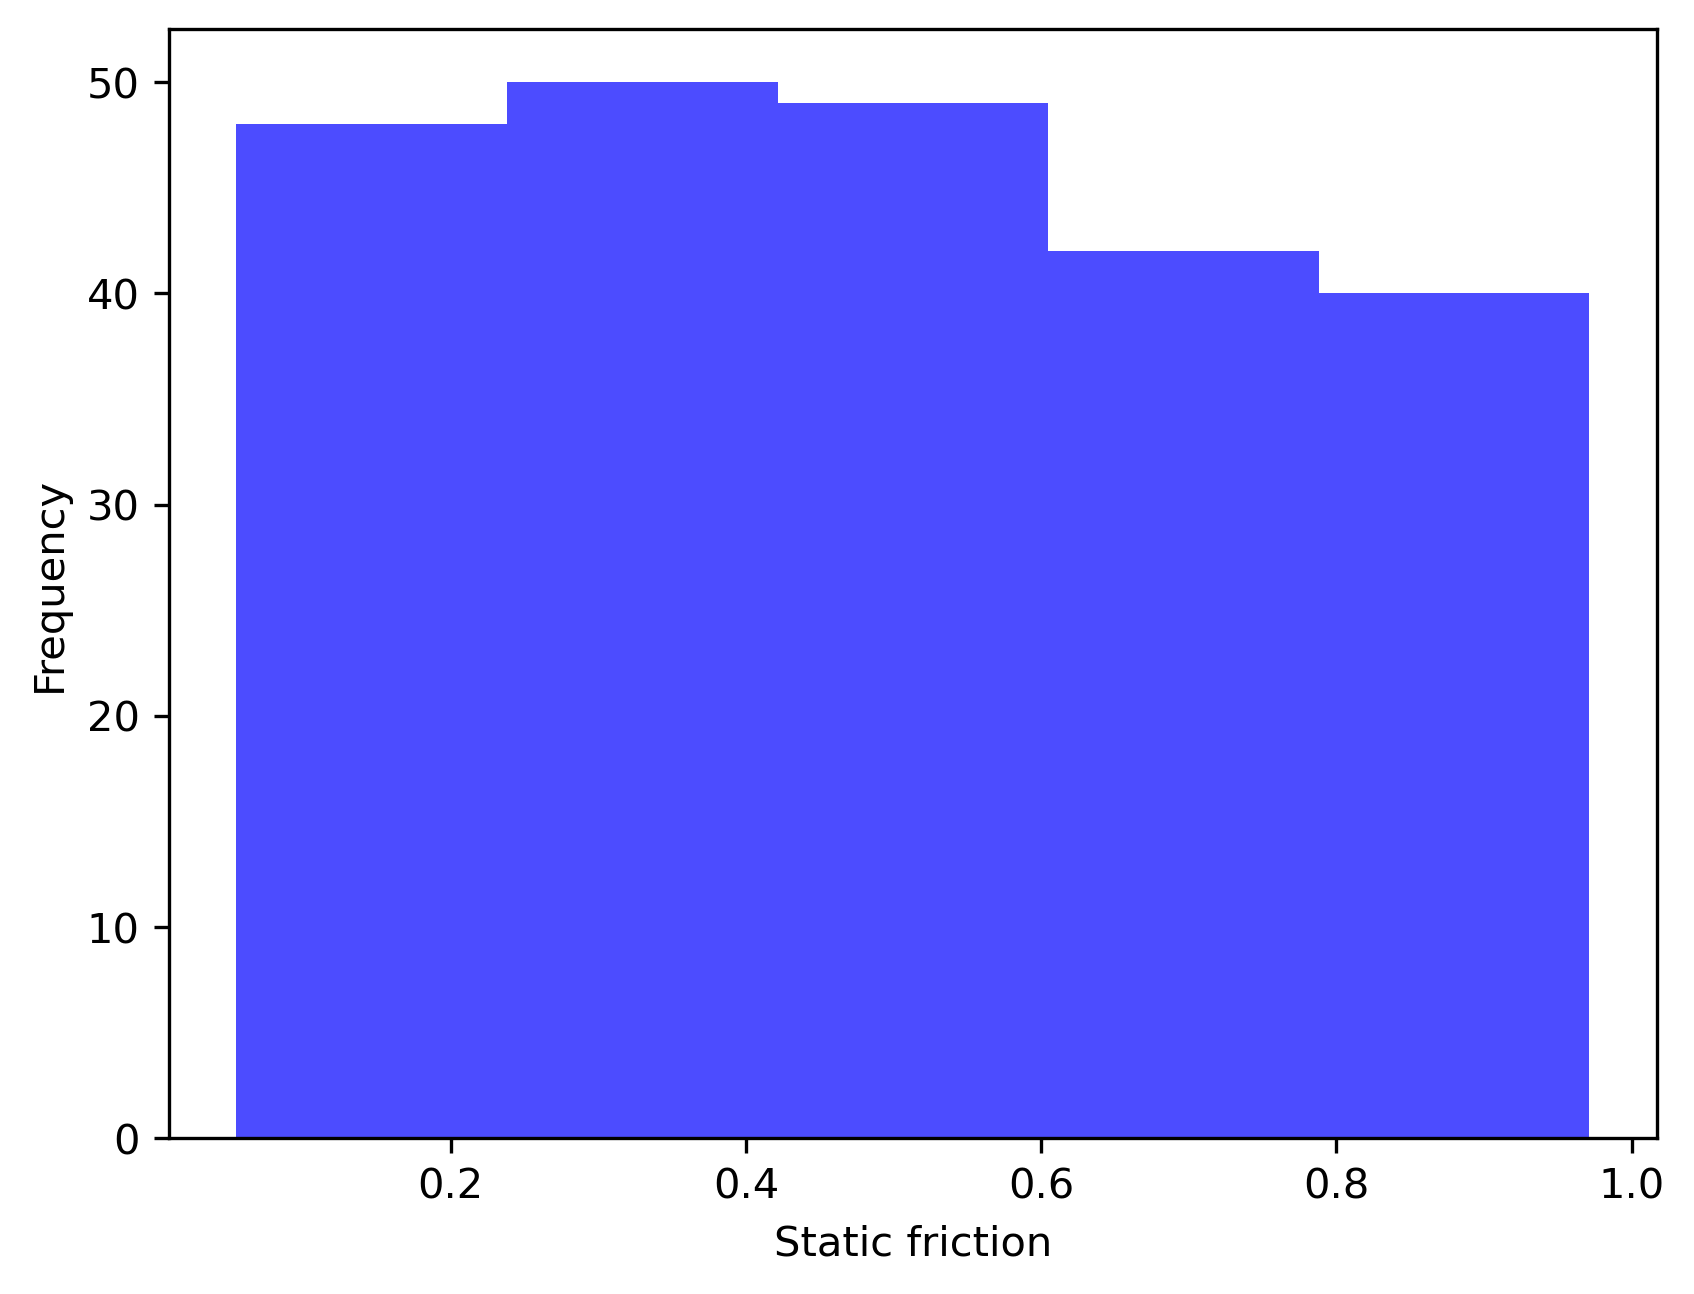

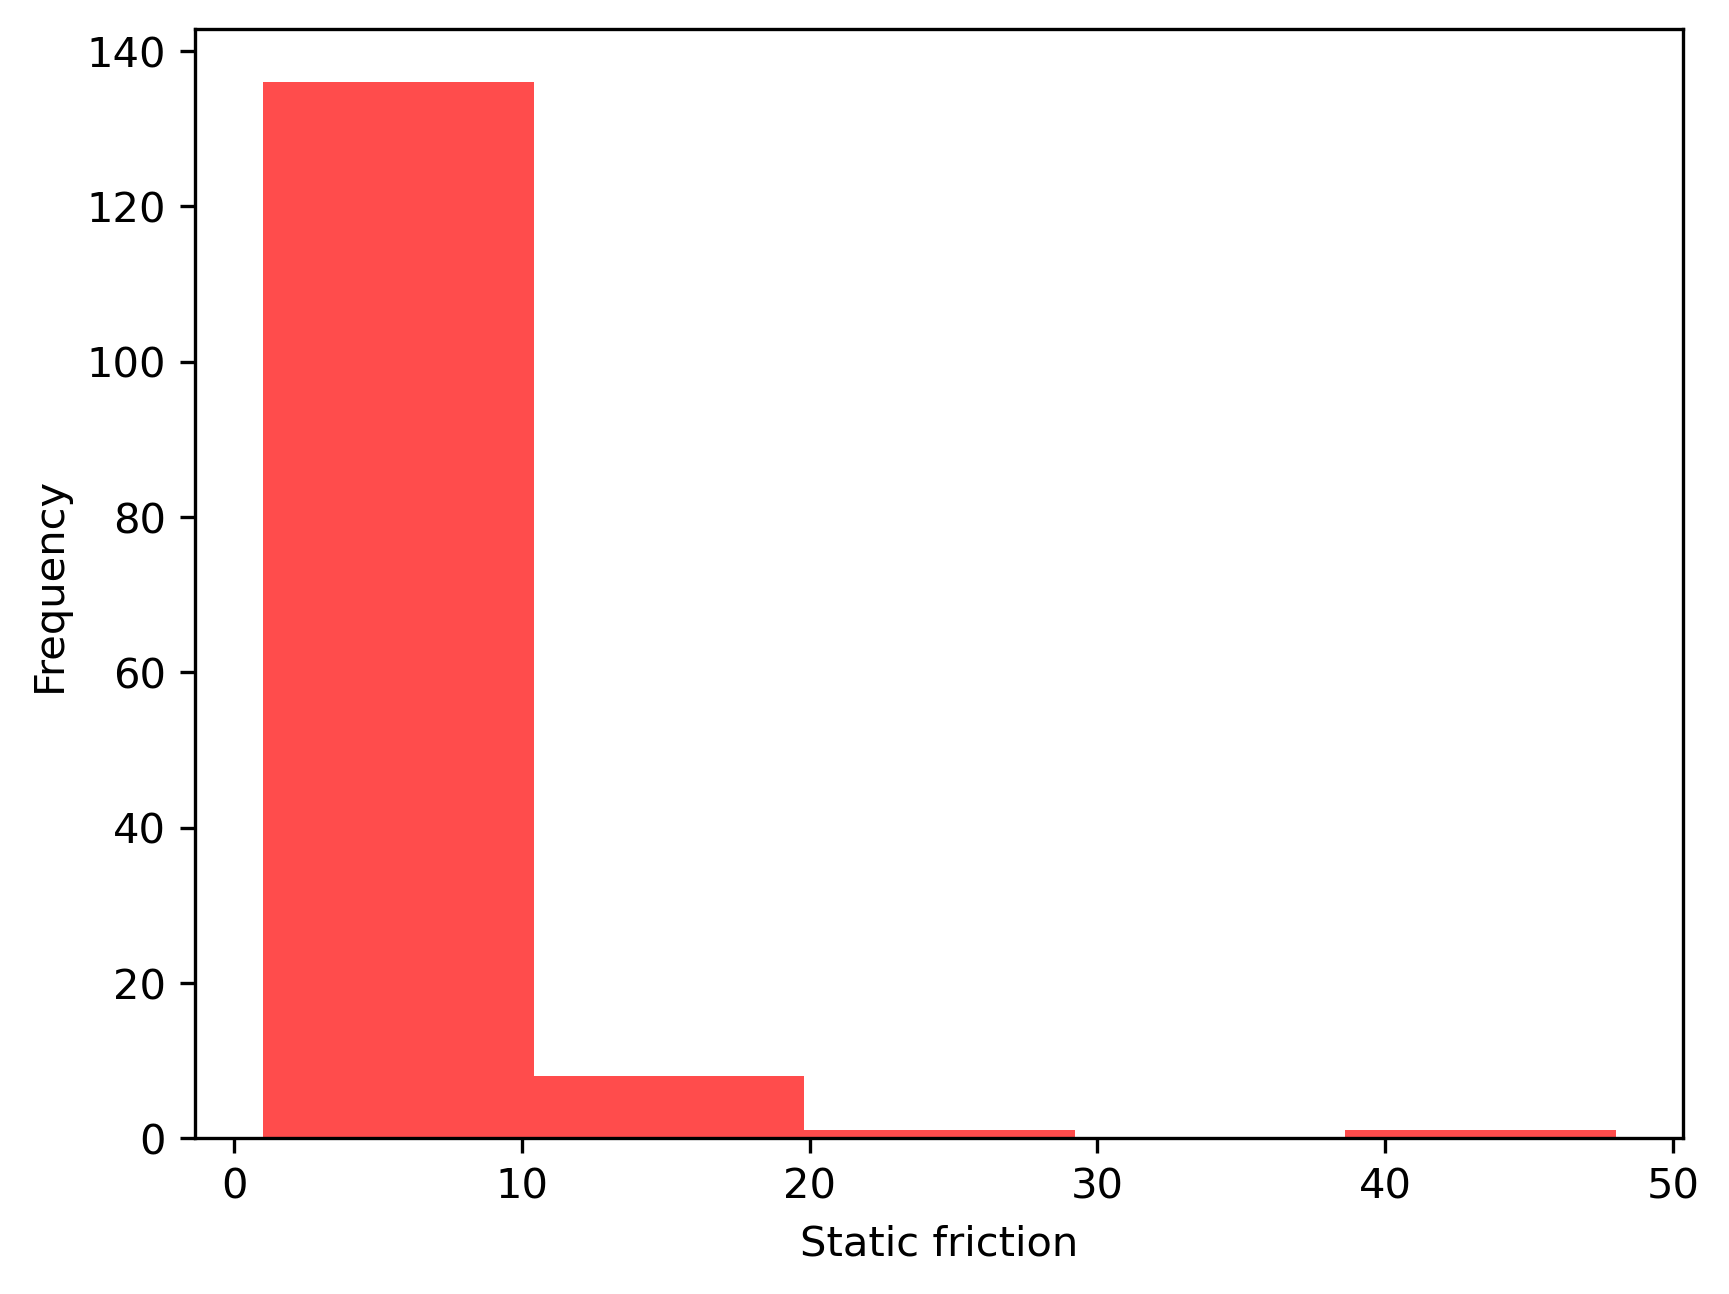

In [237]:

static_friction_flattened = list(chain.from_iterable(static_friction))
static_friction_flattened = np.array(static_friction_flattened)
# Plotting the histogram
values_larger_than_1 = static_friction_flattened[static_friction_flattened > 1]
values_smaller_than_1 = static_friction_flattened[static_friction_flattened < 1]
values_smaller_than_1 = values_smaller_than_1[values_smaller_than_1 > 0.05]
plt.figure(dpi=300)
plt.hist(values_smaller_than_1, bins=5, alpha=0.7, color='blue')
plt.xlabel('Static friction')
plt.ylabel('Frequency')

plt.figure(dpi=300)
plt.hist(values_larger_than_1, bins=5, alpha=0.7, color='red')
plt.xlabel('Static friction')
plt.ylabel('Frequency')


plt.show()
